In [7]:
import pandas as pd
from pathlib import Path
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from matplotlib import cm
from panel.interact import interact

%matplotlib inline

In [3]:
def clean_up_income_data(year):
    if (year >=2004 and year <= 2006) or year == 2008:
        rows_to_skip = 6
    elif year==2007:
        rows_to_skip = 5
    elif year > 2008:
        rows_to_skip = 3

    # Get last two digits of year as input to reading path of data file
    if year-2000 < 10:
        year_str = f"0{year-2000}"
    else: year_str = f"{year-2000}"

    # Read excel file and skip title and description rows
    xls_path = Path(f"Data/Income/{year_str}zp33ny.xls")

    # Path to use
    if year < 2008:
        path_to_use = f"Data/Income/ZIP Code {year} NY.xls"
    else: path_to_use = f"Data/Income/{year_str}zp33ny.xls"

    # Read excel file and skip title and description rows
    xls_path = Path(path_to_use)
    df_xls = pd.read_excel(xls_path, skiprows=rows_to_skip, index_col=None, na_values=['NA'])
    
    if year == 2004 or year == 2005:
        df_xls.rename(columns={ df_xls.columns[0]: "Size of Adjusted Gross Income" }, inplace = True)
        df_xls['Size of Adjusted Gross Income'] = df_xls['Size of Adjusted Gross Income'].astype(str)
        df_xls.loc[df_xls['Size of Adjusted Gross Income'].str[:1]=='1','Zip'] = df_xls['Size of Adjusted Gross Income']
        df_xls['Zip'].fillna(method='ffill',inplace=True)
        df_xls.loc[:, ['Size of Adjusted Gross Income','Zip']].head(30)
    
    if year == 2006:
        df_xls.rename(columns={ df_xls.columns[0]: "Size of Adjusted Gross Income" }, inplace = True)
        df_xls.rename(columns={ df_xls.columns[1]: "Zip" }, inplace = True)
    
    
    # Choose relevant columns
    if year >= 2004 and year <= 2006:
        zip_col = np.where(df_xls.columns.str.contains('Zip'))[0][0]
        income_bracket_col = np.where(df_xls.columns.str.contains('Size of Adjusted Gross Income'))[0][0]
    elif year >= 2007 and year <= 2008:
        zip_col = df_xls.columns.get_loc('Zip Code')
        income_bracket_col = np.where(df_xls.columns.str.contains('Size of Adjusted Gross Income'))[0][0]        
    else:
        zip_col = np.where(df_xls.columns.str.contains('ZIP'))[0][0]
        income_bracket_col = np.where(df_xls.columns.str.contains('Size of adjusted gross income'))[0][0]
    
    
    if year >= 2004 and year <= 2006:
        AGI_col = df_xls.columns.get_loc('Adjusted Gross Income')
    else: AGI_col = np.where(df_xls.columns.str.contains('Adjusted gross income'))[0][0]
        
    nbr_returns_col = df_xls.columns.get_loc('Number of returns')
    
    df_xls = df_xls.iloc[:, [zip_col,income_bracket_col,nbr_returns_col,AGI_col]]
    
    # Rename columns for consistency
    df_xls.columns=(['ZIP','Income Bracket','Nbr of Returns','Adjusted Gross Income'])
    
    # Take only the rows where it shows total of each ZIP code
    # Step 1: Drop rows where ZIP is null
    df_xls = df_xls.drop(df_xls[df_xls['ZIP'].isnull()].index)
    
    df_xls.loc[df_xls['Income Bracket']==df_xls['ZIP'],'Income Bracket'] = 'Total'
    df_xls = df_xls.drop(df_xls[df_xls['ZIP']==0].index)
    df_xls = df_xls.drop(df_xls[df_xls['Nbr of Returns'].isnull()].index)
    df_xls = df_xls.drop(df_xls[df_xls['Nbr of Returns']=='          '].index)
    df_xls = df_xls.drop(df_xls[df_xls['ZIP']=='TOTAL'].index)

    df_xls.dropna()
    
    # Convert Nbr of Returns and AGI to float
    df_xls= df_xls.replace('.','0')
    df_xls= df_xls.replace('*','0')
    df_xls= df_xls.replace('*         ','0')
    df_xls= df_xls.replace('*              ','0')
    df_xls= df_xls.replace('--        ','0')
    df_xls= df_xls.replace('--             ','0')
    df_xls= df_xls.replace('          ','0')
    df_xls= df_xls.replace('               ','0')
    
    df_xls['Income Bracket'].fillna('Total',inplace=True)
    
    
    df_xls['Nbr of Returns']=df_xls['Nbr of Returns'].astype('float')
    df_xls['Adjusted Gross Income']=df_xls['Adjusted Gross Income'].astype('float')
    df_xls['ZIP'] = df_xls['ZIP'].astype(int)
    df_xls['ZIP'] = df_xls['ZIP'].astype(str)

    # Add average income column and year
    df_xls['Average_Income'] = df_xls['Adjusted Gross Income'] / df_xls['Nbr of Returns']
    df_xls['Year'] = year
    
    # Set ZIP as index
    #df_xls = df_xls.set_index('ZIP')
    
    return df_xls

In [4]:
df = pd.concat([
    clean_up_income_data(2004),
    clean_up_income_data(2005),
    clean_up_income_data(2006),
    clean_up_income_data(2007),
    clean_up_income_data(2008),
    clean_up_income_data(2009),
    clean_up_income_data(2010),
    clean_up_income_data(2011),
    clean_up_income_data(2012),
    clean_up_income_data(2013),
    clean_up_income_data(2014),
    clean_up_income_data(2015),
    clean_up_income_data(2016)],
    axis='rows',join='inner')

df

//anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


ZIP           Income Bracket  Nbr of Returns  Adjusted Gross Income  \
20     10001                    Total         11553.0               976187.0   
21     10001    Under $10,000                  2330.0                -5951.0   
22     10001    $10,000 under $25,000          2220.0                37644.0   
23     10001    $25,000 under $50,000          2647.0                97163.0   
24     10001    $50,000 under $75,000          1520.0                92723.0   
...      ...                      ...             ...                    ...   
12324  99999    $25,000 under $50,000         19130.0               697118.0   
12325  99999    $50,000 under $75,000         11920.0               733893.0   
12326  99999   $75,000 under $100,000          7490.0               648279.0   
12327  99999  $100,000 under $200,000         11100.0              1529415.0   
12328  99999         $200,000 or more          7840.0              9125834.0   

       Average_Income  Year  
20          84.496408  2004  
21          -2.554077  2004  
22          16.956757  2004  
23          36.706838  2004  
24          61.001974  2004  
...               ...   ...  
12324       36.441087  2016  
12325       61.568205  2016  
12326       86.552603  2016  
12327      137.785135  2016  
12328     1164.009439  2016  

[158833 rows x 6 columns]

In [5]:
df_total = df[df['Income Bracket']=='Total']
df_pivot = df_total.pivot(index='Year', columns='ZIP', values=['Average_Income'])
df_pivot

Average_Income                                                   \
ZIP           10001      10002       10003        10004        10005   
Year                                                                   
2004      84.496408  28.299890  124.118277  1192.090515  1020.734056   
2005      98.615572  30.843708  143.042118  1291.139676   873.867018   
2006     115.796522  33.569826  168.975739   461.884146   908.440161   
2007     134.949392  34.468048  186.429558   399.250438  1109.426747   
2008     122.949178  38.548899  184.124475   494.552110   639.172876   
2009     132.718147  37.445179  158.433641   254.236649   628.092457   
2010     128.706560  40.064717  182.328356   292.801618   736.585495   
2011     129.849742  41.327069  185.716370   299.349465   653.019811   
2012     144.040526  44.740451  204.008413   363.621074   983.553943   
2013     152.670700  46.126446  209.104499   345.791473   944.133569   
2014     167.894886  51.084667  231.834686   364.337402   941.570289   
2015     165.547589  53.304978  248.250516   404.103213   614.329545   
2016     157.802755  54.090256  231.083112   330.628226   529.540572   

                                                                ...  \
ZIP        10006       10007      10008      10009       10010  ...   
Year                                                            ...   
2004  157.037886  221.089431  57.155925  50.245214  111.270800  ...   
2005  157.177167  314.862012  63.421502  54.990728  134.803846  ...   
2006  165.452210  291.571171  65.560068  60.922676  161.580510  ...   
2007  180.534347  352.059544  72.546457  60.005672  196.343407  ...   
2008  171.953936  433.150943  66.447273  61.975795  180.275386  ...   
2009  154.007420  367.214883        NaN  62.517857  153.265387  ...   
2010  168.917838  413.964355        NaN  62.479564  173.512158  ...   
2011  204.561649  422.140023        NaN  66.592799  185.031565  ...   
2012  176.241991  476.188663        NaN  69.934461  211.518652  ...   
2013  178.666949  495.033526        NaN  71.493441  198.265084  ...   
2014  179.886939  611.060597        NaN  77.468328  227.345641  ...   
2015  193.605761  597.923123        NaN  79.680777  231.156751  ...   
2016  194.157806  879.035756        NaN  79.423573  225.699078  ...   

                                                                        \
ZIP       14897      14898      14901      14902      14903      14904   
Year                                                                     
2004  29.850543  31.076087  29.147791  34.231405  42.996872  28.624802   
2005  30.636119  33.122966  29.785440  33.848980  47.454289  30.296149   
2006  33.896175  32.327928  30.270151  39.889447  49.189617  30.573294   
2007  32.522936  31.731629  25.923077  33.544061  45.467342  27.412781   
2008  37.939850  34.087542  31.238734        NaN  50.905870  32.412308   
2009  45.709424  35.891003  31.866798        NaN  51.468827  32.357420   
2010  46.728460  38.317376  33.252745        NaN  55.160011  33.739119   
2011  41.056701  37.276740  35.198784        NaN  57.794942  33.668933   
2012  41.987179  39.054237  34.803411        NaN  57.334324  34.953078   
2013  45.344737  39.631034  34.846679        NaN  57.290934  34.776323   
2014  45.321622  41.672581  35.585714        NaN  59.370081  36.278571   
2015  49.002778  42.793220  36.039154        NaN  61.039782  36.229872   
2016  46.074286  42.255172  36.320265        NaN  61.505278  36.270579   

                                                   
ZIP       14905        501       6390       99999  
Year                                               
2004  51.810515        NaN        NaN         NaN  
2005  54.367177        NaN        NaN         NaN  
2006  60.064324        NaN  87.937888         NaN  
2007  59.087701  21.343537  87.795031         NaN  
2008  59.754471  10.328185        NaN         NaN  
2009  57.585190        NaN        NaN         NaN  
2010  60.133423        NaN        NaN         NaN  
2011  63.6

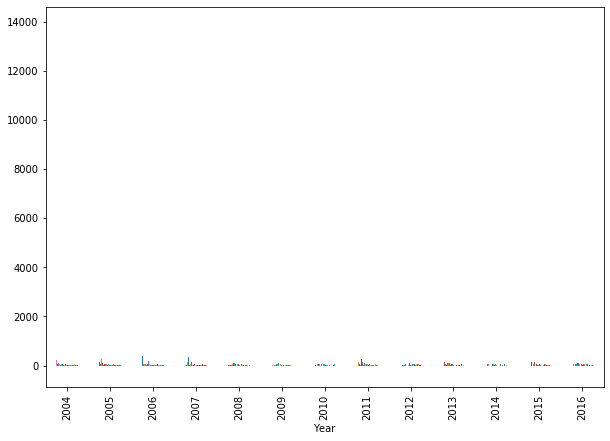

In [10]:
df_pivot.plot.bar(figsize=(10,7),legend=False)

In [11]:
df_total.hvplot.bar()

:Bars   [index,Variable]   (value)